This notebook compares performance between regression model and naive formula model in population prediction. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

In [2]:
# Retrieve data from abs
dls = "https://www.abs.gov.au/statistics/people/population/regional-population/2021/32180DS0003_2001-21.xlsx"
urllib.request.urlretrieve(dls, "../data/raw/population_2001-21.xlsx")  # For Python 3
# Read population record from 2001-2021 from Excel file Table 1, skip first 6 irrelevant rows, and assign column names
df = pd.read_excel("../data/raw/population_2001-21.xlsx",sheet_name='Table 1',skiprows=6,header = 1)
# Filter the records in the state of Victoria
df_vic = df.loc[df['S/T name'] == 'Victoria']

# Rename to keep column names correct
df_vic = df_vic.rename(columns = {'no.':'2001','no..1':'2002','no..2':'2003','no..3':'2004','no..4':'2005',
                     'no..5':'2006','no..6':'2007','no..7':'2008','no..8':'2009','no..9':'2010',
                     'no..10':'2011','no..11':'2012','no..12':'2013','no..13':'2014','no..14':'2015',
                     'no..15':'2016','no..16':'2017','no..17':'2018','no..18':'2019',
                     'no..19':'2020','no..20':'2021','no..21':'2021-2020=','%':'2021-2020%'}, inplace = False)
# Drop irrelevant columns 
df_VIC = df_vic.drop(columns=['GCCSA code', 'GCCSA name', 'SA4 code',
       'SA4 name', 'SA3 code', 'SA3 name','Unnamed: 31'])

In [3]:
# Show the top 10 suburb in Victoria where population increase the most from 2020 to 2021
df_VIC[['SA2 code','SA2 name','2001','2011','2020','2021', '2021-2020=', '2021-2020%']].sort_values('2021-2020%',ascending=False).head(10)

,SA2 code,SA2 name,2001,2011,2020,2021,2021-2020=,2021-2020%
707,206051131.0,Port Melbourne Industrial,9.0,15.0,1268.0,1472.0,1457.0,9713.3
810,209041437.0,Wollert,389.0,528.0,20910.0,24762.0,24234.0,4589.8
841,210051445.0,Mickleham - Yuroke,873.0,1579.0,18372.0,23477.0,21898.0,1386.8
898,212031301.0,Cranbourne East,1123.0,8344.0,55489.0,61850.0,53506.0,641.3
957,213041359.0,Rockbank - Mount Cottrell,1760.0,2772.0,13272.0,17836.0,15064.0,543.4
840,210051444.0,Craigieburn - West,55.0,4247.0,22106.0,23408.0,19161.0,451.2
807,209041434.0,Mernda,831.0,6395.0,23077.0,23634.0,17239.0,269.6
966,213051366.0,Truganina,745.0,11544.0,36327.0,38668.0,27124.0,235.0
971,213051466.0,Point Cook - South,38.0,6440.0,19346.0,19385.0,12945.0,201.0
882,212011287.0,Beaconsfield - Officer,3707.0,8223.0,22826.0,24101.0,15878.0,193.1


A couple of things to note in the ranking above: 
1. 2021-2020 is a good indicator for population growth in a long run;
2. Due to the low base, digit increase might result in great growth rate, indicating possible outliers

Now let's predict the years using the formula
    $$P_{next} = P_{current}*(1+\frac{P_{current}-P_{prev}}{P_{prev}+0.1})$$
and compare with actual records

In [4]:
# Create a list of years 
YEAR_LIST = ['2001','2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019','2020', '2021']
predict_df = pd.DataFrame()
i = 0
while i<19:
    #plus one to avoid divided by zero error
    predict_df[YEAR_LIST[i+2]] = df_vic[YEAR_LIST[i+1]]*(1+(df_vic[YEAR_LIST[i+1]] - df_vic[YEAR_LIST[i]])/(df_vic[YEAR_LIST[i]]+0.1))
    i=i+1
          
predict_df    
    #df_VIC[year] = round(df_vic['2012']*(1+(df_vic['2012'] - df_vic['2011'])/df_vic['2011']))

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
577,6447.607443,6500.628404,6672.553749,6820.352896,6875.918999,7318.019168,7518.049388,7972.079234,8184.293009,9049.435553,9711.729156,10415.201532,11002.077166,11787.526228,12724.867897,13478.251525,14462.402544,15354.317261,16614.566195
578,11922.870533,12330.047275,12365.518381,12349.524403,12443.616207,12460.218418,12552.417211,12472.001314,12448.015822,12268.755788,12349.005241,12347.002064,12302.050801,12273.059357,12302.000073,12221.130395,12213.047174,12385.446887,12056.331871
579,20908.987749,21093.083576,21163.258646,21268.854405,21424.994152,21707.131091,21982.768999,22139.857780,22496.521714,22634.965334,22801.575323,23104.653469,23143.894020,23423.934770,23871.633611,24136.746078,24227.594451,24440.730907,24363.168747
580,20354.060150,20425.015803,20221.424279,20532.584328,20645.602744,21294.919772,22043.940634,22420.286538,23416.020100,23732.250731,23693.672178,23952.751059,24407.257139,24545.535825,25017.273612,25316.389051,25550.181983,25547.786338,25384.004806
581,5479.171613,5719.620807,5683.713088,6103.990089,6222.528675,6226.462060,6375.386016,6615.121975,6763.179627,6857.560537,6985.472543,7116.463781,7181.373720,7301.676071,7433.000807,7504.259236,7419.004779,7491.204651,7286.925551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,3506.210394,3543.293409,3511.000000,3473.103358,3426.312792,3519.259316,3513.040927,3479.034875,3430.258732,3380.463570,3492.377884,3538.485200,3541.137771,3557.102043,3574.091066,3711.665111,3782.505216,3889.182569,4016.068974
1035,6690.029383,6648.117361,6610.163613,6633.003839,6666.029316,6560.318787,6656.094231,6775.780685,6775.192806,6819.236827,6749.033412,6734.033486,6719.033560,6698.048381,6702.007400,6719.003652,6768.108175,6839.355446,6957.013343
1036,8457.588306,8513.472476,8524.161572,8547.105690,8685.827465,8788.004488,8891.103530,8964.840232,9052.851567,9083.387625,9312.264459,9434.928167,9466.739852,9551.751095,9740.952277,9759.632733,9865.873331,9893.367744,9851.008146
1037,17854.193425,18007.395717,18150.510417,18410.077504,18890.972249,19232.571969,19339.801119,19634.591220,19902.624252,20127.055933,20634.034453,20977.361747,21252.904508,21507.934061,21669.384987,21912.552576,22195.069657,22382.266184,22603.223296


In [5]:
# check the record of Alfredton with SA2 code = 201011001 
bd = df_VIC.loc[df['SA2 code'] ==201011001]
bd = bd[['2001','2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020','2021']].T
bd=bd.reset_index().rename(columns={577:'population','index':'year'})
# This is the actual record of population of Alfredton in the timeframe of 10 years
bd

,year,population
0,2001,5756.0
1,2002,6092.0
2,2003,6293.0
3,2004,6480.0
4,2005,6648.0
5,2006,6761.0
6,2007,7034.0
7,2008,7272.0
8,2009,7614.0
9,2010,7894.0


Let's check performance of linear regression model compared to the formula

In [6]:
# Fit linear regression model to predict 2020 population
x = bd.iloc[:, 0].values.reshape(-1, 1)
y = bd.iloc[:, 1].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)
y_pred = model.predict([[2020]])
y_pred

array([[14269.32251082]])

Linear regression gets 14269 for 2020 Alfredton compared to actual record of 15472.

In [7]:
predict_df['2020']

577     15354.317261
578     12385.446887
579     24440.730907
580     25547.786338
581      7491.204651
            ...     
1034     3889.182569
1035     6839.355446
1036     9893.367744
1037    22382.266184
1038    13280.082162
Name: 2020, Length: 462, dtype: float64

We can see our prediction for record 577 which is the first SA2 Alfredton is 15354 which is much closer to the actual record than llinear regression model.

The growth rate is quite steady in most recent years.

In [8]:
true_df = df_vic[['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', '2021']]

In [9]:
df_2003_2021_error = predict_df - true_df

In [11]:
# To fill null values with zero to be able to plot
predict_df_imputed = predict_df.fillna(0)

In [12]:
mean_squared_error(true_df['2021'],predict_df_imputed['2021'])

399115.870778537

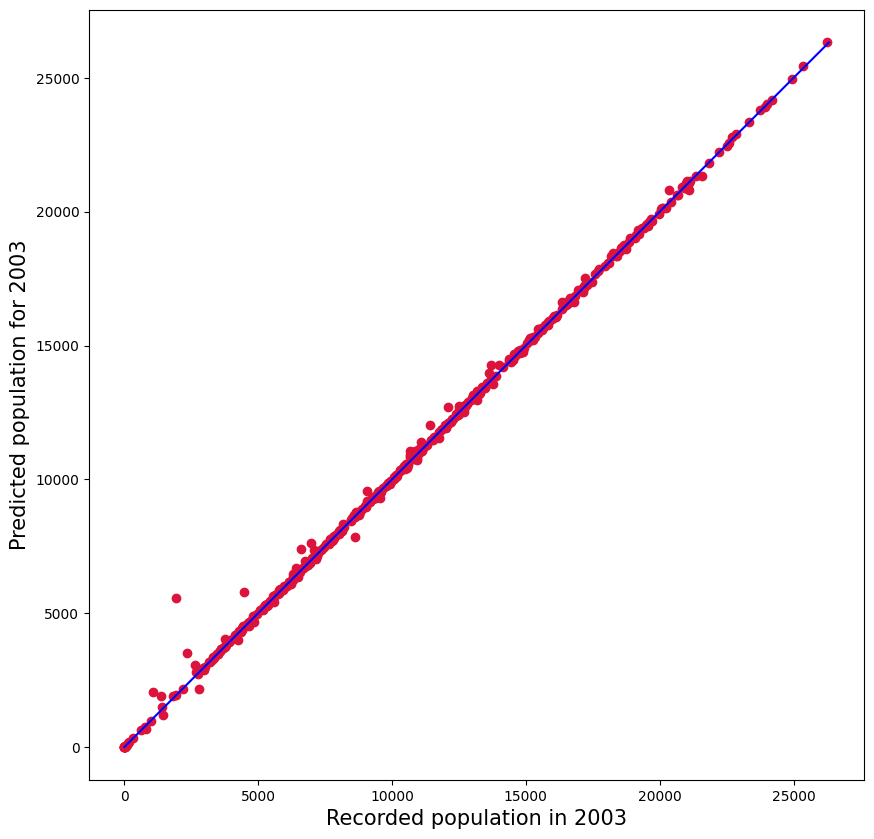

In [13]:
# plot to see the formula correctness
plt.figure(figsize=(10,10))
plt.scatter(true_df['2003'], predict_df_imputed['2003'], c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predict_df_imputed['2003']), max(true_df['2003']))
p2 = min(min(predict_df_imputed['2003']), min(true_df['2003']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('')
plt.xlabel('Recorded population in 2003', fontsize=15)
plt.ylabel('Predicted population for 2003', fontsize=15)
plt.axis('equal')
plt.show()

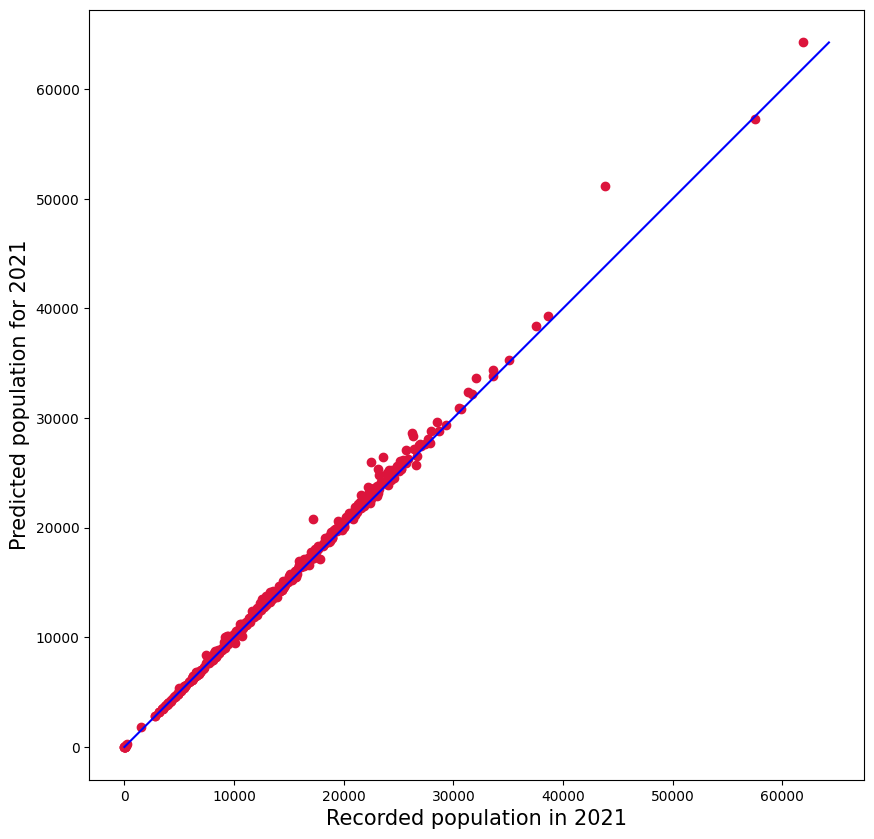

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(true_df['2021'], predict_df_imputed['2021'], c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predict_df_imputed['2021']), max(true_df['2021']))
p2 = min(min(predict_df_imputed['2021']), min(true_df['2021']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('')
plt.xlabel('Recorded population in 2021', fontsize=15)
plt.ylabel('Predicted population for 2021', fontsize=15)
plt.axis('equal')
plt.show()

Bias exists but acceptable.

In [15]:
# Compute the prediction for future three years and add 1 to avoid zeron in denominator
df_vic['p2013'] = df_vic['2012']*(1+(df_vic['2012'] - df_vic['2011'])/(df_vic['2011']+1))
df_vic['p2022'] = df_vic['2021']*(1+(df_vic['2021'] - df_vic['2020'])/(df_vic['2020']+1))
df_vic['p2023'] = df_vic['p2022']*(1+(df_vic['p2022'] - df_vic['2021'])/(df_vic['2021']+1))
df_vic['p2024'] = df_vic['p2023']*(1+(df_vic['p2023'] - df_vic['p2022'])/(df_vic['p2022']+1))

In [16]:
df_vic.to_csv('../data/curated/population_prediction.csv')

https://pages.uoregon.edu/rgp/PPPM613/class8a.htm

The annual growth of a population may be shown by the equation: I = rN (K-N / K), where I = the annual increase for the population, r = the annual growth rate, N = the population size, and K = the carrying capacity.